In [1]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from collections import Counter
import os
import glob

import numpy as np

In [2]:
pathToPos = 'PositiveWithDESSky'
pathToNeg = 'DES/DES_Processed'

In [3]:
folders = {}
for root, dirs, files in os.walk(pathToPos):
    for folder in dirs:
        key = folder
        value = os.path.join(root, folder)
        folders[key] = value
        
# subf = []
# for folder in folders:
#     subf.append(folder[len(pathToPos)])

In [4]:
#number of Positive DataPoints
nDT = len(folders)

DataPos = np.zeros([nDT, 3, 100, 100])

# key is name of folder number
# value is the number of the folder to be added to the file name

counter = 0
for key, value in folders.items():

    g_name = get_pkg_data_filename(value + '/' + str(key) + '_g_norm.fits')
    r_name = get_pkg_data_filename(value + '/' + str(key) + '_r_norm.fits')
    i_name = get_pkg_data_filename(value + '/' + str(key) + '_i_norm.fits')

    # g_name = get_pkg_data_filename(value + '/' + str(key) + '_posSky_g.fits')
    # r_name = get_pkg_data_filename(value + '/' + str(key) + '_posSky_r.fits')
    # i_name = get_pkg_data_filename(value + '/' + str(key) + '_posSky_i.fits')
    
    g = fits.open(g_name)[0].data[0:100,0:100]
    r = fits.open(r_name)[0].data[0:100,0:100]
    i = fits.open(i_name)[0].data[0:100,0:100]
    
    DataPos[counter] = [g, r, i] 
    counter += 1
#    if counter > 1500:
#        break

In [5]:
#Loading negative examples

# r=root, d=directories, f = files

foldersNeg = []
for root, dirs, files in os.walk(pathToNeg):
    for folder in dirs:
        foldersNeg.append(os.path.join(root, folder))

In [6]:
nDT = len(foldersNeg)
DataNeg = np.zeros([nDT,3,100,100])

for var in range(len(foldersNeg)):

    # g_name = get_pkg_data_filename(foldersNeg[var]+'/g_WCSClipped.fits')
    # r_name = get_pkg_data_filename(foldersNeg[var]+'/r_WCSClipped.fits')
    # i_name = get_pkg_data_filename(foldersNeg[var]+'/i_WCSClipped.fits')    

    g_name = get_pkg_data_filename(foldersNeg[var]+'/g_norm.fits')
    r_name = get_pkg_data_filename(foldersNeg[var]+'/r_norm.fits')
    i_name = get_pkg_data_filename(foldersNeg[var]+'/i_norm.fits')    

    g = fits.open(g_name)[0].data[0:100,0:100]
    r = fits.open(r_name)[0].data[0:100,0:100]
    i = fits.open(i_name)[0].data[0:100,0:100]    
    
    DataNeg[var] = [g, r, i]
#    if var > 1500:
#        break

In [7]:
def norm(x):
    m = x.mean()
    v = x.std()
    return (x-m)/v

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


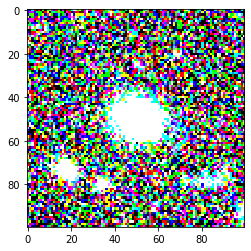

In [8]:
from matplotlib import pyplot
im2disp = DataNeg[2].transpose((1,2,0))
pyplot.imshow(im2disp)
pyplot.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


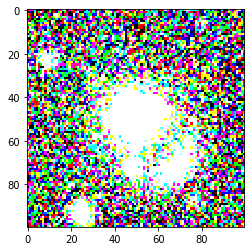

In [9]:
im2disp = DataPos[2].transpose((1,2,0))
pyplot.imshow(im2disp)
pyplot.show()

In [10]:
DataPos.std()

132.90657831747913

In [11]:
DataNeg.std()

110.37919762630314

In [12]:
AllData = np.vstack((DataPos, DataNeg))

In [13]:
AllData.std()

122.16615919733925

In [14]:
# Gaussian normalization of the data
for i in range(DataPos.shape[0]):
    for j in range(DataPos.shape[1]):
        DataPos[i,j] = norm(DataPos[i,j])
        #print(DataPos.std())

for i in range(DataNeg.shape[0]):
    for j in range(DataNeg.shape[1]):
        DataNeg[i,j] = norm(DataNeg[i,j])
        #print(DataNeg.std())
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


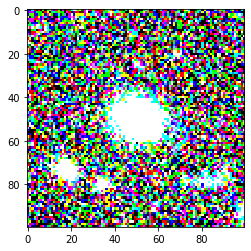

In [14]:
from matplotlib import pyplot
im2disp = DataNeg[2].transpose((1,2,0))
pyplot.imshow(im2disp)
pyplot.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


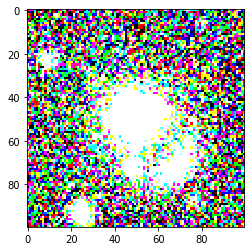

In [15]:
im2disp = DataPos[2].transpose((1,2,0))
pyplot.imshow(im2disp)
pyplot.show()

In [16]:
# We need to create train and test "datasets",
# let's say 80% images for training and 20% for test from every group

In [17]:
DataPos.shape[0]
DataNeg.shape[0]

10000

In [18]:
import numpy.random as rnd
rnd.seed(2019) #fix seed for reproducibility of results 

listPos = list(np.arange(DataPos.shape[0]))
listPosTest = list(rnd.choice(listPos,int(DataPos.shape[0]*0.2), replace=False))
listPosRem = list(set(listPos)-set(listPosTest))
listPosVal = list(rnd.choice(listPosRem,int(DataPos.shape[0]*0.2), replace=False))
listPosTrain = list(set(listPosRem)-set(listPosVal))


listNeg = list(np.arange(DataPos.shape[0],DataPos.shape[0]+DataNeg.shape[0]))
listNegTest  = list(rnd.choice(listNeg,int(DataNeg.shape[0]*0.2), replace=False))
listNegRem = list(set(listNeg)-set(listNegTest))
listNegVal  = list(rnd.choice(listNegRem,int(DataNeg.shape[0]*0.2), replace=False))
listNegTrain = list(set(listNegRem)-set(listNegVal))

listTest  = listPosTest  + listNegTest
rnd.shuffle(listTest)
listVal  = listPosVal  + listNegVal
rnd.shuffle(listVal)
listTrain = listPosTrain + listNegTrain
rnd.shuffle(listTrain)

In [19]:
#Now we are ready to create X_train, Y_train and X_test and Y_test

Ntest  = len(listTest)
Nval   = len(listVal)
Ntrain = len(listTrain)

X_train = np.zeros([Ntrain,3,100,100])
Y_train = np.zeros(Ntrain, dtype=int)

X_test = np.zeros([Ntest,3,100,100])
Y_test = np.zeros(Ntest, dtype=int)

X_val = np.zeros([Nval,3,100,100])
Y_val = np.zeros(Nval, dtype=int)


for i in range(Ntest):
    if listTest[i]<DataPos.shape[0]:
        X_test[i] = DataPos[listTest[i]]
        Y_test[i] = 1
    else:
        X_test[i] = DataNeg[listTest[i]-DataPos.shape[0]]
        Y_test[i] = 0

for i in range(Nval):
    if listVal[i]<DataPos.shape[0]:
        X_val[i] = DataPos[listVal[i]]
        Y_val[i] = 1
    else:
        X_val[i] = DataNeg[listVal[i]-DataPos.shape[0]]
        Y_val[i] = 0        
        
for i in range(Ntrain):
    if listTrain[i]<DataPos.shape[0]:
        X_train[i] = DataPos[listTrain[i]]
        Y_train[i] = 1
    else:
        X_train[i] = DataNeg[listTrain[i]-DataPos.shape[0]]
        Y_train[i] = 0

In [20]:
X_test  = X_test.transpose(0,2,3,1)
X_val   = X_val.transpose(0,2,3,1)
X_train = X_train.transpose(0,2,3,1)

In [21]:
#Now we are almost ready to create CNN :)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout

In [23]:
model = Sequential()
model.add(Conv2D(8, kernel_size = (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [24]:
model.fit(X_train, Y_train, epochs=30, batch_size=200, validation_data=(X_val, Y_val))

Train on 12000 samples, validate on 4000 samples
Epoch 1/30
12000/12000 [==============================] - 63s 5ms/step - loss: 7.8848 - acc: 0.5009 - val_loss: 7.9752 - val_acc: 0.4997
Epoch 2/30
12000/12000 [==============================] - 40s 3ms/step - loss: 7.9725 - acc: 0.4999 - val_loss: 7.9752 - val_acc: 0.4997
Epoch 3/30
12000/12000 [==============================] - 29s 2ms/step - loss: 7.9725 - acc: 0.4999 - val_loss: 7.9752 - val_acc: 0.4997
Epoch 4/30
12000/12000 [==============================] - 29s 2ms/step - loss: 7.9725 - acc: 0.4999 - val_loss: 7.9752 - val_acc: 0.4997
Epoch 5/30
12000/12000 [==============================] - 30s 3ms/step - loss: 7.9725 - acc: 0.4999 - val_loss: 7.9752 - val_acc: 0.4997
Epoch 6/30
12000/12000 [==============================] - 28s 2ms/step - loss: 7.9725 - acc: 0.4999 - val_loss: 7.9752 - val_acc: 0.4997
Epoch 7/30
12000/12000 [==============================] - 38s 3ms/step - loss: 7.9725 - acc: 0.4999 - val_loss: 7.9752 - val_acc:

In [25]:
# You can add more layers, DropOut and others

In [26]:
model.save_weights('model_baseline.h5')

In [27]:
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print("accuracy on the test set ->", acc * 100.0)

accuracy on the test set -> 50.0


In [28]:
np.round(model.predict(X_test))

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total para

In [30]:
# DataPos.dump('DataPos.pkl')
# DataNeg.dump('DataNeg.pkl')

# Test 47 good and 47 bad images.

In [31]:
# get path names for good and bad sources, where good sources are the 
# known sources and the bad sources are the unknown sources

pathToKnown = 'KnownLenses/DES2017/'
pathToUnknown = 'KnownLenses/Unknown_Processed/'

In [32]:
# Loading known examples from Jacobs paper

# r=root, d=directories, f = files

foldersKnown = []
for root, dirs, files in os.walk(pathToKnown):
    for folder in dirs:
        foldersKnown.append(os.path.join(root, folder))

In [33]:
nDT = len(foldersKnown)
DataKnown = np.zeros([nDT,3,100,100])

for var in range(len(foldersKnown)):

    # g_name = get_pkg_data_filename(foldersKnown[var]+'/g_WCSClipped.fits')
    # r_name = get_pkg_data_filename(foldersKnown[var]+'/r_WCSClipped.fits')
    # i_name = get_pkg_data_filename(foldersKnown[var]+'/i_WCSClipped.fits')    

    g_name = get_pkg_data_filename(foldersKnown[var]+'/g_norm.fits')
    r_name = get_pkg_data_filename(foldersKnown[var]+'/r_norm.fits')
    i_name = get_pkg_data_filename(foldersKnown[var]+'/i_norm.fits')    
  
    g = fits.open(g_name)[0].data[0:100,0:100]
    r = fits.open(r_name)[0].data[0:100,0:100]
    i = fits.open(i_name)[0].data[0:100,0:100]    
    
    DataKnown[var] = [g, r, i]

In [34]:
# Loading unknown examples from DES

foldersUnknown = []
for root, dirs, files in os.walk(pathToUnknown):
    for folder in dirs:
        foldersUnknown.append(os.path.join(root, folder))

In [35]:
nDT = len(foldersUnknown)
DataUnknown = np.zeros([nDT,3,100,100])

for var in range(len(foldersUnknown)):
    # g_name = get_pkg_data_filename(foldersUnknown[var]+'/g_WCSClipped.fits')
    # r_name = get_pkg_data_filename(foldersUnknown[var]+'/r_WCSClipped.fits')
    # i_name = get_pkg_data_filename(foldersUnknown[var]+'/i_WCSClipped.fits')    

    g_name = get_pkg_data_filename(foldersUnknown[var]+'/g_norm.fits')
    r_name = get_pkg_data_filename(foldersUnknown[var]+'/r_norm.fits')
    i_name = get_pkg_data_filename(foldersUnknown[var]+'/i_norm.fits')    

    g = fits.open(g_name)[0].data[0:100,0:100]
    r = fits.open(r_name)[0].data[0:100,0:100]
    i = fits.open(i_name)[0].data[0:100,0:100]    
    
    DataUnknown[var] = [g, r, i]

In [36]:
DataKnown = DataKnown.transpose(0, 3, 2, 1)
np.round(model.predict(DataKnown))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [37]:
print("DataKnown Mean: " + str(DataKnown.mean()))
print("DataKnown Std: " + str(DataKnown.std()))


DataKnown Mean: 6.440405920221704
DataKnown Std: 129.41103505049463


In [38]:
y = np.round(model.predict(DataKnown))
Ones = np.count_nonzero(y == 1.)
print("Ones: " + str(Ones))
Zeroes = (np.count_nonzero(y == 0))
print("Zeroes: " + str(Zeroes))


Ones: 47
Zeroes: 0


In [39]:
DataUnknown = DataUnknown.transpose(0, 3, 2, 1 )
np.round(model.predict(DataUnknown))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [40]:
print("DataUnknown Mean: " + str(DataUnknown.mean()))
print("DataUnknown Std: " + str(DataUnknown.std()))

DataUnknown Mean: 5.149189540418116
DataUnknown Std: 36.93292495435067


In [41]:
y = np.round(model.predict(DataUnknown))
Ones = np.count_nonzero(y == 1.)
print("Ones: " + str(Ones))
Zeroes = (np.count_nonzero(y == 0))
print("Zeroes: " + str(Zeroes))



Ones: 47
Zeroes: 0
